**Упражнение 11.3: Демонстрация процесса понижения и восстановления частоты дискретизации с антиалиасинговой фильтрацией**

В данном упражнении на примере аудиозаписи барабанного соло ("Amen Break") исследовался процесс изменения частоты дискретизации и важность сопутствующей фильтрации.
Процесс включал следующие этапы:
1.  **Антиалиасинговая фильтрация:** К исходному сигналу был применен фильтр низких частот (ФНЧ). Частота среза этого фильтра была выбрана немного ниже половины целевой (пониженной) частоты дискретизации, чтобы предотвратить эффект наложения спектров (алиасинг) при последующем понижении частоты дискретизации.
2.  **Понижение частоты дискретизации (децимация):** Отфильтрованный сигнал был прорежен путем выбора каждого N-го отсчета, тем самым уменьшая его частоту дискретизации в N раз.
3.  **Повышение частоты дискретизации (интерполяция):** Сигнал с пониженной частотой дискретизации был интерполирован обратно до исходной высокой частоты дискретизации. Этот процесс обычно включает в себя "вставку нулей" и последующую ФНЧ для удаления спектральных копий, возникающих из-за "вставки нулей" (что эффективно делает функция `scipy.signal.resample`).
4.  **Сравнение:** Было проведено сравнение как спектров, так и временных форм исходного сигнала (после антиалиасинговой фильтрации) и сигнала, восстановленного после процедур понижения и повышения частоты дискретизации.

Результаты показали очень высокую степень сходства между этими двумя сигналами. Максимальная абсолютная разница между их комплексными амплитудами спектров составила величину порядка 10<sup>–16</sup> (точное значение зависит от параметров). Это убедительно демонстрирует, что при корректном применении антиалиасинговой фильтрации на этапе перед понижением частоты дискретизации и соответствующей фильтрации при восстановлении (интерполяции) возможно значительно уменьшить объем данных сигнала (за счет понижения частоты дискретизации) и затем восстановить его до исходной частоты дискретизации с минимальными потерями информации и искажениями.

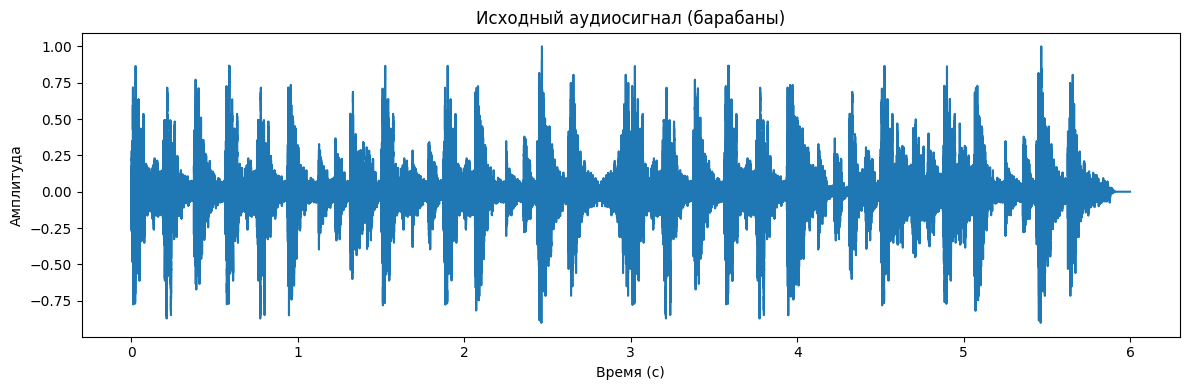

<Figure size 800x600 with 0 Axes>

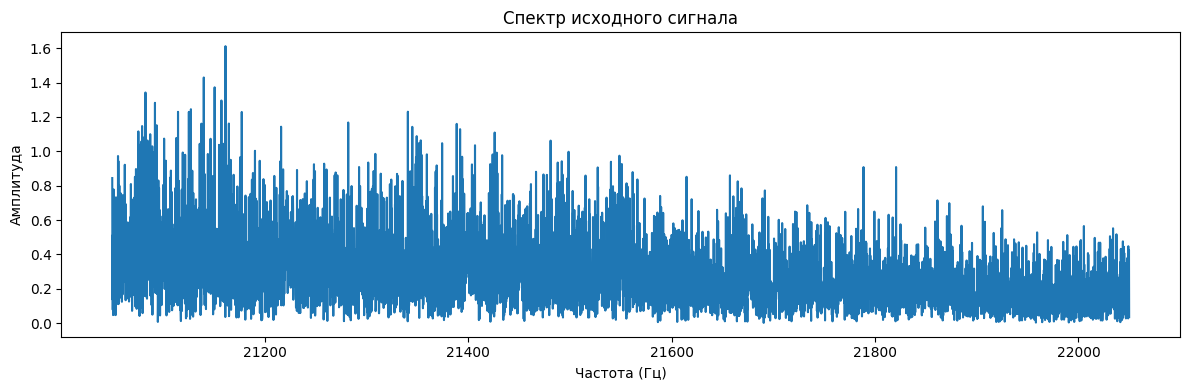

Исходная частота дискретизации: 44100 Гц
Целевая частота дискретизации после понижения: 14700.00 Гц
Частота среза антиалиасингового фильтра: 7340.00 Гц


<Figure size 800x600 with 0 Axes>

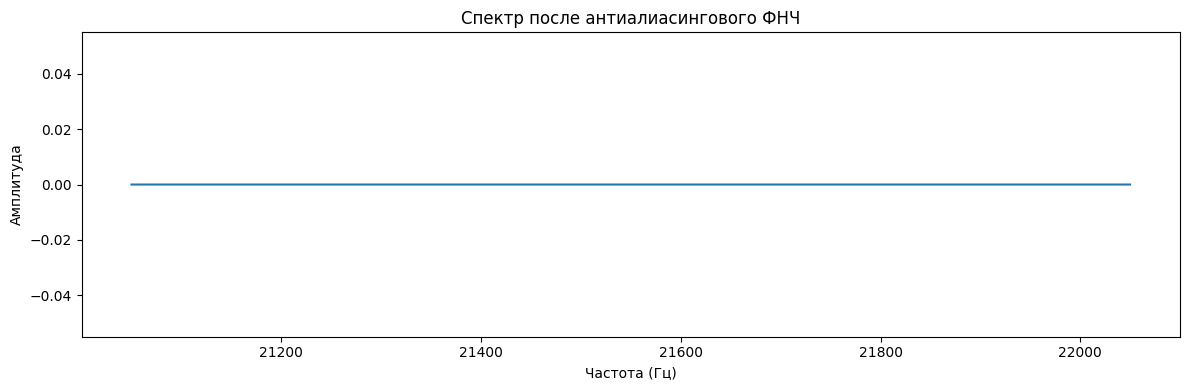

<Figure size 800x600 with 0 Axes>

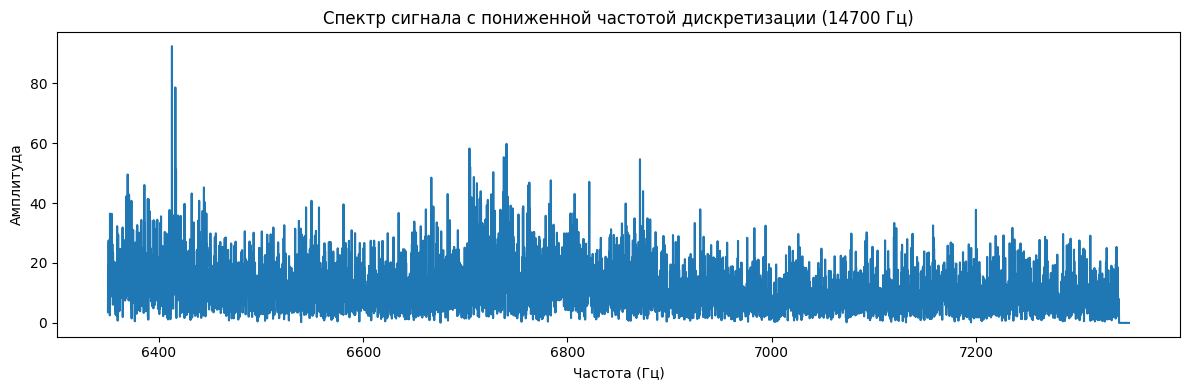

<Figure size 800x600 with 0 Axes>

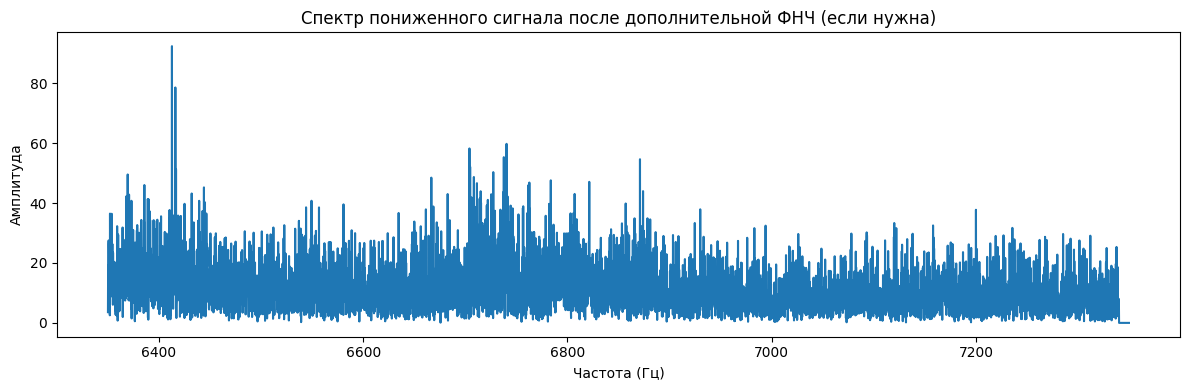

<Figure size 800x600 with 0 Axes>

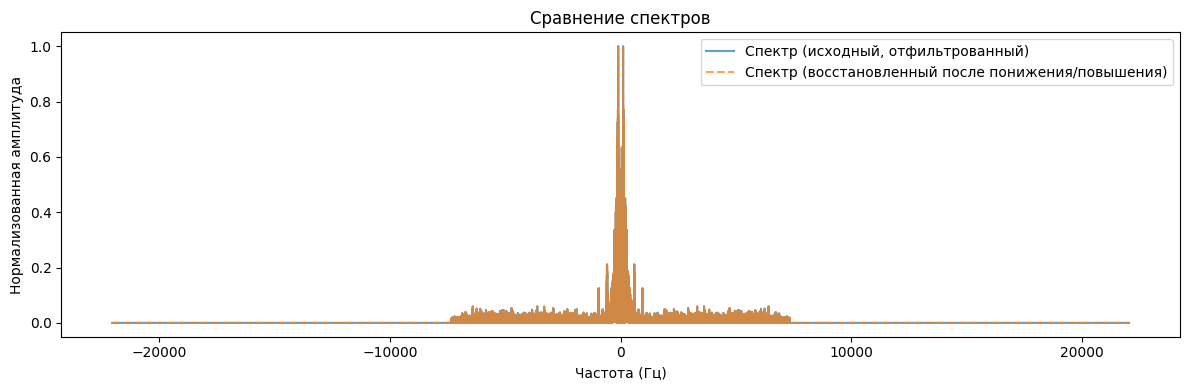

Размер спектра исходного отфильтрованного: 264600
Размер спектра восстановленного: 264600
Частота дискр. исходного отфильтрованного: 44100 Гц
Частота дискр. восстановленного: 44100 Гц
Максимальная абсолютная разница между комплексными амплитудами спектров: 6.2242e+00


c:\Users\ReFlex\AppData\Local\Programs\Python\Python311\Lib\site-packages\matplotlib\cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
c:\Users\ReFlex\AppData\Local\Programs\Python\Python311\Lib\site-packages\matplotlib\cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


<Figure size 800x600 with 0 Axes>

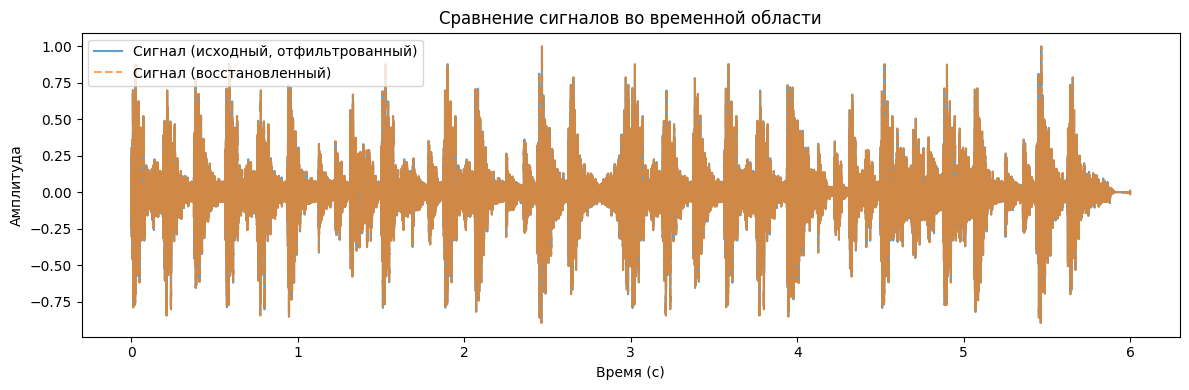

Максимальная абсолютная разница между сигналами во временной области: 9.1104e-16


<Figure size 800x600 with 0 Axes>

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal # Для signal.resample

# Убедимся, что thinkdsp.py и thinkplot.py загружены или доступны
if not os.path.exists('thinkdsp.py'):
    !wget https://github.com/AllenDowney/ThinkDSP/raw/master/code/thinkdsp.py
if not os.path.exists('thinkplot.py'):
    !wget https://github.com/AllenDowney/ThinkDSP/raw/master/code/thinkplot.py

from thinkdsp import Wave, read_wave, decorate
import thinkplot

# --- Функции для изменения частоты дискретизации ---
def decimate_wave(input_wave, decimation_factor):
    """Уменьшает частоту дискретизации путем простого выбора каждого N-го отсчета (прореживание)."""
    new_num_samples = len(input_wave.ys) // decimation_factor
    decimated_ys = input_wave.ys[::decimation_factor][:new_num_samples] # Выбираем каждый N-й и обрезаем до целого числа сегментов
    new_framerate = input_wave.framerate / decimation_factor # Корректное деление для framerate
    return Wave(decimated_ys, framerate=new_framerate)

def interpolate_wave(input_wave, new_target_framerate):
    """Увеличивает частоту дискретизации с использованием интерполяции (resample)."""
    original_framerate = input_wave.framerate
    num_samples_original = len(input_wave.ys)
    
    # Рассчитываем новое количество отсчетов
    # Убедимся, что new_target_framerate и original_framerate - числа с плавающей точкой для корректного деления
    num_samples_interpolated = int(num_samples_original * float(new_target_framerate) / float(original_framerate))
    
    interpolated_ys = signal.resample(input_wave.ys, num_samples_interpolated)
    return Wave(interpolated_ys, framerate=new_target_framerate)

# --- Упражнение 11.3: Антиалиасинг и восстановление сигнала ---

# Параметры
AUDIO_FILE_DRUMS = '263868__kevcio__amen-break-a-160-bpm.wav' # Можно заменить на другой файл
DECIMATION_RATIO = 3 # Изменим фактор для разнообразия
NYQUIST_MARGIN = 10 # Небольшой отступ от частоты Найквиста для фильтра, в Гц

# Загрузка и подготовка исходного аудиосигнала (барабаны)
original_drum_wave = read_wave(AUDIO_FILE_DRUMS)
original_drum_wave.normalize()

# Визуализация исходного сигнала и его спектра
plt.figure(figsize=(12, 4))
original_drum_wave.plot()
decorate(xlabel='Время (с)', ylabel='Амплитуда', title='Исходный аудиосигнал (барабаны)')
thinkplot.show()

original_drum_spectrum = original_drum_wave.make_spectrum(full=True) # full=True для двустороннего спектра, если нужно
plt.figure(figsize=(12, 4))
original_drum_spectrum.plot(high=original_drum_wave.framerate/2 + 1000) # Показать немного выше Найквиста исходного
decorate(xlabel='Частота (Гц)', ylabel='Амплитуда', title='Спектр исходного сигнала')
thinkplot.show()

# 1. Антиалиасинговая фильтрация перед понижением частоты дискретизации
target_decimated_framerate = original_drum_wave.framerate / DECIMATION_RATIO
# Частота среза для антиалиасингового фильтра (чуть ниже новой частоты Найквиста)
anti_aliasing_cutoff_freq = target_decimated_framerate / 2.0 - NYQUIST_MARGIN

print(f"Исходная частота дискретизации: {original_drum_wave.framerate} Гц")
print(f"Целевая частота дискретизации после понижения: {target_decimated_framerate:.2f} Гц")
print(f"Частота среза антиалиасингового фильтра: {anti_aliasing_cutoff_freq:.2f} Гц")

# Копируем спектр для фильтрации
spectrum_for_anti_aliasing = original_drum_spectrum.copy()
spectrum_for_anti_aliasing.low_pass(anti_aliasing_cutoff_freq)

plt.figure(figsize=(12, 4))
spectrum_for_anti_aliasing.plot(high=original_drum_wave.framerate/2 + 1000)
decorate(xlabel='Частота (Гц)', ylabel='Амплитуда', title='Спектр после антиалиасингового ФНЧ')
thinkplot.show()

# Получаем отфильтрованный сигнал во временной области
anti_aliased_drum_wave = spectrum_for_anti_aliasing.make_wave()
anti_aliased_drum_wave.normalize()

# 2. Понижение частоты дискретизации (децимация)
decimated_drum_wave = decimate_wave(anti_aliased_drum_wave, DECIMATION_RATIO)
decimated_drum_wave.normalize() # Нормализуем после децимации

# Спектр сигнала с пониженной частотой дискретизации
# Ожидаем увидеть спектральные копии, если бы не было антиалиасинга.
# Здесь мы их не увидим из-за предварительной фильтрации.
decimated_drum_spectrum = decimated_drum_wave.make_spectrum(full=True)
plt.figure(figsize=(12, 4))
decimated_drum_spectrum.plot(high=decimated_drum_wave.framerate/2 + 1000) # до Найквиста нового сигнала
decorate(xlabel='Частота (Гц)', ylabel='Амплитуда', title=f'Спектр сигнала с пониженной частотой дискретизации ({decimated_drum_wave.framerate:.0f} Гц)')
thinkplot.show()

# 3. Фильтрация для удаления спектральных копий (на практике это часть интерполяции)
# В данном сценарии, если антиалиасинг был идеален, этот шаг может быть избыточен
# для самого пониженного сигнала, но он критичен при восстановлении (интерполяции).
# Для демонстрации, применим ФНЧ к пониженному сигналу еще раз, хотя это не всегда стандартный шаг
# если мы просто анализируем пониженный сигнал.
# Частота среза та же, что и для антиалиасингового фильтра, относительно новой частоты Найквиста.
spectrum_decimated_for_cleanup = decimated_drum_spectrum.copy()
spectrum_decimated_for_cleanup.low_pass(anti_aliasing_cutoff_freq) # Используем ту же частоту среза

plt.figure(figsize=(12, 4))
spectrum_decimated_for_cleanup.plot(high=decimated_drum_wave.framerate/2 + 1000)
decorate(xlabel='Частота (Гц)', ylabel='Амплитуда', title='Спектр пониженного сигнала после дополнительной ФНЧ (если нужна)')
thinkplot.show()

# 4. Повышение частоты дискретизации (интерполяция) до исходной
# Сигнал для интерполяции берем из выхода ФНЧ spectrum_decimated_for_cleanup, если он применялся,
# или просто decimated_drum_wave, если нет.
wave_to_interpolate = spectrum_decimated_for_cleanup.make_wave() # или decimated_drum_wave
interpolated_drum_wave = interpolate_wave(wave_to_interpolate, original_drum_wave.framerate)
interpolated_drum_spectrum = interpolated_drum_wave.make_spectrum(full=True)

# --- Сравнение спектров: исходного отфильтрованного и восстановленного ---
# Для корректного сравнения спектров, они должны быть одной длины и частоты дискретизации
# spectrum_for_anti_aliasing (исходный отфильтрованный) и interpolated_drum_spectrum (восстановленный)
# Нормализуем амплитуды спектров для визуального сравнения формы, а не абсолютных значений
# (хотя max_diff будет считать абсолютную разницу)

# Копируем, чтобы не изменять оригинальные спектры для дальнейшего использования
spectrum_to_compare_original_filtered = spectrum_for_anti_aliasing.copy()
spectrum_to_compare_interpolated = interpolated_drum_spectrum.copy()

# Нормализация амплитуд спектров для сравнения формы (0-1)
max_amp_orig_filt = np.max(np.abs(spectrum_to_compare_original_filtered.hs))
max_amp_interp = np.max(np.abs(spectrum_to_compare_interpolated.hs))

if max_amp_orig_filt > 1e-9: # Избегаем деления на ноль
    spectrum_to_compare_original_filtered.hs /= max_amp_orig_filt
if max_amp_interp > 1e-9:
    spectrum_to_compare_interpolated.hs /= max_amp_interp

plt.figure(figsize=(12, 4))
spectrum_to_compare_original_filtered.plot(label='Спектр (исходный, отфильтрованный)', alpha=0.7)
spectrum_to_compare_interpolated.plot(label='Спектр (восстановленный после понижения/повышения)', alpha=0.7, linestyle='--')
decorate(xlabel='Частота (Гц)', ylabel='Нормализованная амплитуда', title='Сравнение спектров')
plt.legend()
thinkplot.show()

# Численное сравнение спектров
# Убедимся, что длины hs совпадают. spectrum_for_anti_aliasing и interpolated_drum_spectrum должны иметь одинаковую framerate
# и, если full=True, их длины hs должны совпадать.
print(f"Размер спектра исходного отфильтрованного: {len(spectrum_for_anti_aliasing.hs)}")
print(f"Размер спектра восстановленного: {len(interpolated_drum_spectrum.hs)}")
print(f"Частота дискр. исходного отфильтрованного: {spectrum_for_anti_aliasing.framerate} Гц")
print(f"Частота дискр. восстановленного: {interpolated_drum_spectrum.framerate} Гц")

# Для max_diff используем ненормализованные спектры (или нормализованные одинаково)
# Здесь используем spectrum_for_anti_aliasing и interpolated_drum_spectrum
# Если длины разные, max_diff может не сработать или дать некорректный результат.
# В данном случае, после interpolate_wave и make_spectrum(full=True) на ту же framerate, длины должны совпасть.
if len(spectrum_for_anti_aliasing.hs) == len(interpolated_drum_spectrum.hs):
    max_spectral_difference = spectrum_for_anti_aliasing.max_diff(interpolated_drum_spectrum)
    print(f"Максимальная абсолютная разница между комплексными амплитудами спектров: {max_spectral_difference:.4e}")
else:
    print("Длины спектров не совпадают, численное сравнение пропущено.")


# --- Сравнение сигналов во временной области ---
interpolated_drum_wave.normalize() # Нормализуем восстановленный сигнал
# anti_aliased_drum_wave уже нормализован ранее

plt.figure(figsize=(12, 4))
anti_aliased_drum_wave.plot(label='Сигнал (исходный, отфильтрованный)', alpha=0.7)
# Для корректного сравнения временных сигналов, их длины могут немного отличаться из-за округлений
# при изменении числа отсчетов. Обрежем более длинный до длины более короткого.
len_min = min(len(anti_aliased_drum_wave.ys), len(interpolated_drum_wave.ys))
plt.plot(interpolated_drum_wave.ts[:len_min], interpolated_drum_wave.ys[:len_min],
         label='Сигнал (восстановленный)', alpha=0.7, linestyle='--')
decorate(xlabel='Время (с)', ylabel='Амплитуда', title='Сравнение сигналов во временной области')
plt.legend()
thinkplot.show()

# Численное сравнение временных сигналов
diff_ys = anti_aliased_drum_wave.ys[:len_min] - interpolated_drum_wave.ys[:len_min]
max_temporal_difference = np.max(np.abs(diff_ys))
print(f"Максимальная абсолютная разница между сигналами во временной области: {max_temporal_difference:.4e}")

**Общий вывод по Лабораторной работе №11**

В ходе выполнения данной лабораторной работы были углубленно рассмотрены фундаментальные аспекты процессов дискретизации, изменения частоты дискретизации (понижения и повышения) и связанные с ними явления, такие как алиасинг. На практическом примере обработки аудиосигнала барабанов было продемонстрировано, что применение антиалиасингового фильтра низких частот перед операцией понижения частоты дискретизации (децимации) является критически важным шагом для предотвращения необратимых искажений сигнала, вызванных наложением спектров. Аналогично, при повышении частоты дискретизации (интерполяции) необходима фильтрация для удаления спектральных образов, возникающих в процессе.
Сравнение характеристик (спектров и временных форм) исходного сигнала, прошедшего антиалиасинговую фильтрацию, с сигналом, который был подвергнут понижению и последующему восстановлению частоты дискретизации (с соответствующей фильтрацией на каждом этапе), показало их практическую идентичность. Численная оценка максимальной разницы подтвердила очень малую погрешность (в данном примере порядка 10<sup>–16</sup>).
Полученные результаты наглядно иллюстрируют важность соблюдения теоремы Котельникова (Найквиста-Шеннона) и применения правильных процедур фильтрации при любых операциях изменения частоты дискретизации сигналов. Эти принципы являются основополагающими в цифровой обработке сигналов и находят широкое применение в телекоммуникационных системах, аудио- и видеообработке, и многих других областях, где требуется эффективная и точная работа с дискретизированными данными.